# EDA 5: Pokročilejší manipulace a agregace


Další čtení pro dlouhé večery v tomto ročním období:
* https://github.com/alanderex/pydata-pandas-workshop/tree/master/notebooks
* https://github.com/TomAugspurger/pandas-head-to-tail/blob/master/notebooks/03-Iterators-Groupby.ipynb
* https://realpython.com/pandas-groupby/

In [1]:
import pandas as pd
%matplotlib inline

## Analýza dat po skupinách

Jedním ze základních postupů v datové analýze je rozdělení dat do skupin, aplikace nějaké operace na jednotlivé skupiny a nakonec kombinace výsledků do vhodného datasetu. Anglicky se tento postup označuje jako *split-apply-combine*. Skupiny jsou často, byť ne nutně, definovány nějakou (kategorickou) proměnnou, např. by to mohla být barva, pohlaví nebo kontinent. Skupiny lze ale vytvářet i odvozováním, např. pomocí rozsahu nebo nebo vlastností časových řad. Oboje už jsme vlastně viděli v EDA 3, kdy jsme skupiny vytvářeli pro deštivé dny nebo jednotlivé roky.

Pojďme si to vysvětlit prakticky. Použijeme k tomu hezký dataset s údaji z amerického Kongresu, který obsahuje seznam všech mužů a žen, kteří kdy v jedné z jeho komor (Sněmovně nebo Senátu) zasedli.

In [2]:
# odkaz přímo na csv soubor na internetu
LEGISLATORS_HISTORICAL_URL_CSV = (
    "https://theunitedstates.io/congress-legislators/legislators-historical.csv"
)

In [3]:
legislators_historical = pd.read_csv(
    LEGISLATORS_HISTORICAL_URL_CSV,
    usecols=["gender", "type", "state", "party", "birthday", "first_name", "last_name"],
    parse_dates=["birthday"],
)

In [4]:
legislators_historical

,last_name,first_name,birthday,gender,type,state,party
0,Bassett,Richard,1745-04-02,M,sen,DE,Anti-Administration
1,Bland,Theodorick,1742-03-21,M,rep,VA,NaN
2,Burke,Aedanus,1743-06-16,M,rep,SC,NaN
3,Carroll,Daniel,1730-07-22,M,rep,MD,NaN
4,Clymer,George,1739-03-16,M,rep,PA,NaN
...,...,...,...,...,...,...,...
12053,Vela,Filemon,1963-02-13,M,rep,TX,Democrat
12054,Reed,Tom,1971-11-18,M,rep,NY,Republican
12055,Delgado,Antonio,1977-01-19,M,rep,NY,Democrat
12056,Walorski,Jackie,1963-08-17,F,rep,IN,Republican


### Krok 1: Split

Na rozdělení dat do skupin slouží metoda [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html?highlight=groupby#pandas.DataFrame.groupby). Nejjednodušší a možná i nejčastější použití je seskupení podle existujícího sloupce v tabulce. Třeba podle `type`, tedy u nás konkrétně podle komory: `rep` je Sněmovna reprezentatntů, `sen` je Senát.

In [5]:
legislators_historical_by_type = legislators_historical.groupby("type")
legislators_historical_by_type

Dostali jsme objekt typu [`GroupBy`](https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html). Pokud vám to připomíná `DatetimeIndexResampler` z [Explorativní analýzy a statistiky jedné proměnné](https://naucse.python.cz/2020/pydata-praha-jaro/pydata/eda-univariate-timeseries/), je to velice dobrá asociace. Tato operace totiž data jen rozdělila do skupin, ještě jsme ale neřekli, co s těmi skupinami chceme dělat.

### Krok 2 + 3: Apply + Combine

Na skupiny, které jsme vytvořili pomocí `groupby`, teď můžeme aplikovat nějakou operaci. To je právě krok *apply*. Nemá pro nás moc cenu oddělovat tento krok od třetího kroku *combine*, protože když už nějakou opraci aplikujeme, tak bychom rádi výsledek sestavili do výsledného datasetu. Pandas navíc tyto kroky sám nijak neodděluje.

*Pozn.: Apply a combine začne být více odděleno v nástrojích na zpracování velkých dat, které už se nevejdou pohodlně do operační paměti počítače a pandas na ně už nestačí. Apply pak probíhá po částech, třeba i distribuovaně na oddělených serverech, a výsledné combine se provádí sesbíráním částečných výsledků.* 

Použijeme teď jednoduchou agregační metodu `count`, která nám vrátí počet hodnot (po skupinách samozřejmě).

In [6]:
legislators_historical_by_type.count()

,last_name,first_name,birthday,gender,state,party
type,,,,,,
rep,10218,10218,9728,10218,10218,9994
sen,1840,1840,1780,1840,1840,1832


Vidíme, že v datech je zaznamenáno 1830 senátorů a 10151 kongresmanů. Na levé straně v indexu vidíme skupiny, podle kterých se dataset agregoval a do sloupců se daly všechny sloupce, na které bylo možné aplikovat naši agregační funkci (v tom případě na všechny zbylé).

Z čísel si můžeš všimnout, že u některých chybí údaje o datu narození nebo straně.

Než aplikujeme krok *apply*, můžeme si vybrat, na který ze sloupců tak učiníme, trochu si tím zpřehledníme výstup. Pokud si vybereme jen jeden sloupec, dostaneme Series.

In [7]:
legislators_historical_by_type['party'].count()

type
rep    9994
sen    1832
Name: party, dtype: int64

Tento krok si můžeme trochu zjednodušit - než abychom se doptávali na `count` nad jedním sloupcem v rámci agregace, můžeme se doptat na *velikost* každé ze skupin.

In [8]:
legislators_historical_by_type.size()

type
rep    10218
sen     1840
dtype: int64

**Úkol:** Rozděl data podle strany (`party`) a vypiš počet záznamů v každé skupině. Dokážeš výsledek setřídit podle velikosti skupin? 

Možná sis všimla, jaký je u výsledku index. Pokud ne, nevadí, určitě si všimneš teď. Zkusíme totiž vytvořit skupiny ne z jednoho sloupce, ale ze dvou. Pojďme si rozdělit zákonodárce podle států, a každou skupinu za jeden stát ještě podle pohlaví.

In [9]:
legislators_by_state_gender_counts = legislators_historical.groupby(["state", "gender"]).count()
legislators_by_state_gender_counts

last_name  first_name  birthday  type  party
state gender                                              
AK    M              17          17        17    17     15
AL    F               4           4         4     4      4
      M             205         205       196   205    205
AR    F               5           5         5     5      5
      M             112         112       109   112    110
...                 ...         ...       ...   ...    ...
WI    M             198         198       198   198    198
WV    F               1           1         1     1      1
      M             119         119       117   119    119
WY    F               1           1         1     1      1
      M              39          39        39    39     39

[105 rows x 5 columns]

Máme tedy skupiny, které jsou definované dvojicí hodnot stát a pohlaví (`state`, `gender`). A to je přesně důvod, proč existuje v Pandas [`MultiIndex`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html).

### Práce s MultiIndex

Vlastnosti MultiIndexu, vlastně takového víceúrovňového či vícerozměrného indexu, můžeme prozkoumat (kromě prostého zobrazení) pomocí několika užitečných atributů (properties).

In [10]:
# počet úrovní 
legislators_by_state_gender_counts.index.nlevels

2

In [11]:
# jména úrovní
legislators_by_state_gender_counts.index.names

FrozenList(['state', 'gender'])

In [12]:
# mohutnost (počet hodnot) jednotlivých úrovní
legislators_by_state_gender_counts.index.levshape

(58, 2)

In [13]:
# hodnoty v jednotlivých úrovních
legislators_by_state_gender_counts.index.levels

FrozenList([['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'DK', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OL', 'OR', 'PA', 'PI', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY'], ['F', 'M']])

Víme tedy, že náš (multi) index má dvě úrovně. Abychom dostali konkrétní řádek, musíme tím pádem zadat dvě hodnoty. K tomu nám poslouží `tuple` (pozor, musí to opravdu být `tuple` a ne `list`, tj. musíme použít kulaté a ne hranaté závorky).

In [14]:
legislators_by_state_gender_counts.loc[("WY", "F")]

last_name     1
first_name    1
birthday      1
type          1
party         1
Name: (WY, F), dtype: int64

Co kdybychom zadali jen polovinu indexu? Dostaneme celou skupinu, v našem případě celý stát.

In [15]:
legislators_by_state_gender_counts.loc["WY"]

,last_name,first_name,birthday,type,party
gender,,,,,
F,1,1,1,1,1
M,39,39,39,39,39


**Otázka:** Jaký je index výsledné tabulky?

Pokud bychom chtěli jedno pohlaví, můžeme indexu změnit pořadí.

In [16]:
swapped_index = legislators_by_state_gender_counts.index.swaplevel(0, 1)
legislators_by_gender_state_counts = legislators_by_state_gender_counts.set_index(swapped_index)
legislators_by_gender_state_counts

last_name  first_name  birthday  type  party
gender state                                              
M      AK            17          17        17    17     15
F      AL             4           4         4     4      4
M      AL           205         205       196   205    205
F      AR             5           5         5     5      5
M      AR           112         112       109   112    110
...                 ...         ...       ...   ...    ...
       WI           198         198       198   198    198
F      WV             1           1         1     1      1
M      WV           119         119       117   119    119
F      WY             1           1         1     1      1
M      WY            39          39        39    39     39

[105 rows x 5 columns]

In [17]:
legislators_by_gender_state_counts.loc["F"].head()

,last_name,first_name,birthday,type,party
state,,,,,
AL,4,4,4,4,4
AR,5,5,5,5,5
AZ,4,4,4,4,4
CA,26,26,26,26,26
CO,3,3,3,3,3


Více o (pokročileší) práci s indexy a multiindexy najdeš v [dokumentaci](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html).

Pokud bychom se chtěli multiindexu "zbavit", můžeme to udělat pomocí `.reset_index()`

In [18]:
legislators_by_state_gender_counts.reset_index().head(5)

,state,gender,last_name,first_name,birthday,type,party
0,AK,M,17,17,17,17,15
1,AL,F,4,4,4,4,4
2,AL,M,205,205,196,205,205
3,AR,F,5,5,5,5,5
4,AR,M,112,112,109,112,110


Anebo rovnou použít `groupby` s `as_index=False`.

In [19]:
legislators_historical.groupby(["state", "gender"], as_index=False).count().head(5)

,state,gender,last_name,first_name,birthday,type,party
0,AK,M,17,17,17,17,15
1,AL,F,4,4,4,4,4
2,AL,M,205,205,196,205,205
3,AR,F,5,5,5,5,5
4,AR,M,112,112,109,112,110


## Co je ten `DataFrameGroupBy object`?

Na začátku jsme si udělali základní agregaci bez aplikace funkcí a dostali jsme jakýsi objekt. Je možné s ním něco dělat, aniž bychom agregovali? Ukazuje se, že ano.

Než se k tomu dostaneme, zkusme jeden **úkol**: Rozděl náš dataframe podle stran - tzn. pro každou stranu vytvoř dataframe a ten ulož do zvláštního souboru. Např. `Democrat` půjde do Democrat.csv atd.

In [20]:
legislators_historical.groupby('party')

Jedna klíčová funkce, kterou nám tento objekt nabízí, je iterace.

In [21]:
groups = legislators_historical.groupby('party')

next(iter(groups)) # timhle ziskame prvni element pri iteraci (for cyklu)

('Adams',
       last_name first_name   birthday gender type state  party
 994       Mills     Elijah 1776-12-01      M  sen    MA  Adams
 1079      Lloyd      James        NaT      M  sen    MA  Adams
 1122  McIlvaine     Joseph 1769-10-02      M  sen    NJ  Adams
 1145     Thomas      Jesse        NaT      M  sen    IL  Adams
 1152   Van Dyke   Nicholas 1770-12-20      M  sen    DE  Adams
 ...         ...        ...        ...    ...  ...   ...    ...
 1398     Holmes       John 1773-03-14      M  sen    ME  Adams
 1429    Silsbee  Nathaniel 1773-01-14      M  sen    MA  Adams
 1472   Chambers    Ezekiel 1788-02-28      M  sen    MD  Adams
 1501  Hendricks    William 1782-11-12      M  sen    IN  Adams
 2033   Harrison    William 1773-02-09      M  sen    OH  Adams
 
 [100 rows x 7 columns])

K čemu nám to může být? Při agregaci se data drasticky zjednodušují a nemusíme si vždy být jisti, že naše agregace jsou napsané správně. Pomocí iterace nad skupinami si můžeme zobrazit všechna data před agregací.

In [22]:
for party, df in legislators_historical.groupby('party'):
    df.to_csv(party + '.csv')

Tuto funkcionalitu asi tolik neoceníte, když jde jen o jeden sloupec, zde `party`, tedy alternativa není tak složitá. Ale jakmile začnete agregovat nad více sloupci, začne být iterace čím dál užitečnější.

## Další agregační funkce

Dosud jsme agregovali jen pomocí `.size` nebo `.count`, ale existuje spousta další agregačních metod, zejm. těch numerických.

Pro snadnější práci s agregacemi budeme používat metodu `.agg`, která akceptuje slovník. Tento slovník udává, *co* chceme agregovat (klíč) a *jak* to chceme agregovat (hodnota). S tím, že způsobů agregace pro jeden sloupec může být více naráz. Ukážeme si.

In [23]:
legislators_historical.groupby('state').agg({'birthday': 'max'}).head()

,birthday
state,
AK,1962-03-30
AL,1976-07-27
AR,1968-08-21
AS,1943-08-15
AZ,1976-11-03


In [24]:
legislators_historical.groupby('state').agg({
    'birthday': ['min', 'max'],
    'party': 'nunique'}
).head()

birthday              party
             min        max nunique
state                              
AK    1848-09-17 1962-03-30       3
AL    1780-01-30 1976-07-27       8
AR    1788-08-25 1968-08-21       5
AS    1937-03-13 1943-08-15       1
AZ    1816-01-24 1976-11-03       3

## Transformace sloupců

Většinu času jsme pracovali s daty, které jsme načetli ze souboru a krom nějakého základního čištění jsme je žádným způsobem neměnili. Teď si ukážeme, jak udělat některé základní transformace.

Může nás například zajímat, které hodnoty máme či nemáme v daném sloupci. K získání takové informace sloužít metody `.isnull` a `.notnull`, které jsou navzájem inverzní.

In [25]:
legislators_historical['party'].isnull()

0        False
1         True
2         True
3         True
4         True
         ...  
12053    False
12054    False
12055    False
12056    False
12057    False
Name: party, Length: 12058, dtype: bool

Series má metodu `isnull`, která nám vrátí True/False hodnoty podle toho, jestli daná hodnota chybí nebo ne (NULL v SQL). Pro snadnější pochopení je možné použít inverzní metodu `notnull`.

Může náš též zajímat, zda řádky nabývají některou z vybraných hodnot.

In [26]:
legislators_historical['first_name'].isin(['Richard', 'John'])

0         True
1        False
2        False
3        False
4        False
         ...  
12053    False
12054    False
12055    False
12056    False
12057    False
Name: first_name, Length: 12058, dtype: bool

... nebo jak se hodnoty liší mezi řádky (dává smysl jen pro číselná data nebo pro sloupce obsahující datum)

In [27]:
legislators_historical['birthday'].diff()

0              NaT
1       -1108 days
2         452 days
3       -4712 days
4        3159 days
           ...    
12053     778 days
12054    3200 days
12055    1889 days
12056   -4904 days
12057   -2580 days
Name: birthday, Length: 12058, dtype: timedelta64[ns]

### .str a .dt metody

Můžeme též testovat různé vlastnosti stringů a dat (od slova datum). Slouží k tomu [.str](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#string-methods) a [.dt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html).

In [28]:
legislators_historical['first_name'].str.len()

0         7
1        10
2         7
3         6
4         6
         ..
12053     7
12054     3
12055     7
12056     6
12057     7
Name: first_name, Length: 12058, dtype: int64

Často používanými metodami v rámci `.str` je `contains` nebo `.lower/upper`

In [29]:
names = pd.Series(['JOHN', 'Jean-Luc', 'Mary-Jane', 'Kate', 'John'])
names.str.contains('-')

0    False
1     True
2     True
3    False
4    False
dtype: bool

In [30]:
names[names.str.contains('-')]

1     Jean-Luc
2    Mary-Jane
dtype: object

Zatímco `.str.contains` použijeme zpravidla na filtrování, `.lower` poslouží třeba na unifikaci dat, která se pak lépe agregují (a deduplikují).

In [31]:
names.value_counts()

JOHN         1
Jean-Luc     1
Mary-Jane    1
Kate         1
John         1
dtype: int64

In [32]:
names.str.lower().value_counts()

john         2
jean-luc     1
mary-jane    1
kate         1
dtype: int64

Z `.dt` si ukážeme jak vytáhnout z data rok.

In [33]:
birth_years = legislators_historical['birthday'].dt.year

birth_years#.value_counts()

0        1745.0
1        1742.0
2        1743.0
3        1730.0
4        1739.0
          ...  
12053    1963.0
12054    1971.0
12055    1977.0
12056    1963.0
12057    1956.0
Name: birthday, Length: 12058, dtype: float64

**Úkol:** vyfiltruj politiky narozené v roce 1980 či později.

## Agregace nad nesloupci

Dosud jsme vždy agregovali nad něčím, co jsme měli v DataFramu. Je ale možné agregovat nad daty, které tam vůbec nemáme, alespoň ne explicitně. K tomu budou sloužit transformace, které jsme si právě ukázali.

Kromě názvu sloupce můžeme do `groupby` vložit nějakou Series (!), která má stejný tvar jako naše sloupce a pandas podle toho bude umět agregovat. Jaká taková Series se nabízí? Nejlépe transformace nějakého existujícího sloupce.

Můžeme tak agregovat data na základě _měsíce_, kdy se daný člověk narodil. A to aniž bychom tento sloupec přidávali do dataframu. Tato metoda nám tak pomůže dělat kreativní agregace bez nutnosti měnit naše data.

In [34]:
legislators_historical.groupby([
    legislators_historical['birthday'].dt.month,
]).size()

birthday
1.0     1049
2.0      984
3.0     1033
4.0      902
5.0      893
6.0      859
7.0      870
8.0      977
9.0      998
10.0    1023
11.0     940
12.0     980
dtype: int64

Můžeme samozřejmě přidávat další a další (ne)sloupce.

In [35]:
legislators_historical.groupby([
    legislators_historical['type'],
    legislators_historical['birthday'].dt.month,
]).size()

type  birthday
rep   1.0         882
      2.0         834
      3.0         887
      4.0         772
      5.0         753
      6.0         747
      7.0         739
      8.0         825
      9.0         833
      10.0        865
      11.0        783
      12.0        808
sen   1.0         167
      2.0         150
      3.0         146
      4.0         130
      5.0         140
      6.0         112
      7.0         131
      8.0         152
      9.0         165
      10.0        158
      11.0        157
      12.0        172
dtype: int64

Měsíce jsou fajn, je jich jen 12, ale co když budeme chtít agregovat nad roky narození?

In [36]:
legislators_historical.groupby([
    legislators_historical['type'],
    legislators_historical['birthday'].dt.year,
]).size().count()

496

Dostáváme poněkud velký dataset, který nám toho moc neřekne. S tím nám pomůže další kapitola.

### Binning

Sice jsme si vytáhli jednotlivé roky narození, ale přeci jen jich je spousta a moc nám to neřekne, určitě se podle nich nedá dobře agregovat.

In [37]:
birth_years = legislators_historical['birthday'].dt.year.astype('Int16')
legislators_historical = legislators_historical.assign(birth_year=birth_years)

<AxesSubplot: >

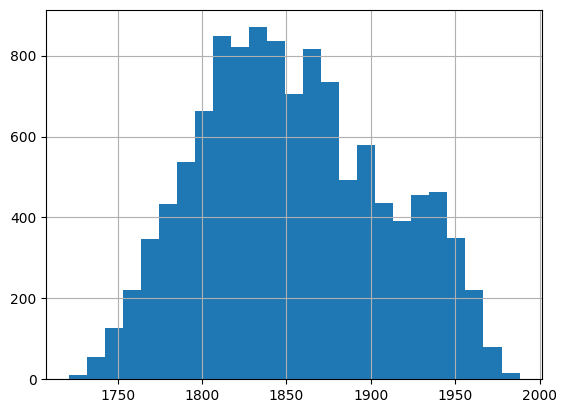

In [38]:
legislators_historical['birth_year'].hist(bins=25)

In [39]:
legislators_historical['birth_year'].value_counts()

1840    94
1824    94
1870    93
1828    92
1812    91
        ..
1987     1
1979     1
1730     1
1721     1
1982     1
Name: birth_year, Length: 262, dtype: Int64

Ani histogram, ani `value_counts` nám žádné moc hodnotné informace nepřinesl. Budeme muset data trochu seskupit. Na to v pandas existuje několik možností.

První z nich je nám již známý `.value_counts`, kterému můžeme přihodit argument `bins`, který znamená, že nechceme frekvence jednotlivých hodnot, ale že chceme seskupit data do několika intervalů.

In [40]:
legislators_historical['birth_year'].value_counts(bins=10)

(1827.8, 1854.5]      2077
(1801.1, 1827.8]      1999
(1854.5, 1881.2]      1884
(1774.4, 1801.1]      1305
(1881.2, 1907.9]      1300
(1907.9, 1934.6]      1055
(1934.6, 1961.3]       963
(1747.7, 1774.4]       648
(1961.3, 1988.0]       164
(1720.732, 1747.7]     113
Name: birth_year, dtype: int64

Co když nám takové samorozdělení nestačí? Na to je `pandas.cut`, resp. `pd.cut`. Má spoustu možností, doporučujeme [projít dokumentaci](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html).

In [41]:
bins = [1700, 1750, 1800, 1850, 1900, 1950]
pd.cut(legislators_historical['birth_year'], bins)

0        (1700.0, 1750.0]
1        (1700.0, 1750.0]
2        (1700.0, 1750.0]
3        (1700.0, 1750.0]
4        (1700.0, 1750.0]
               ...       
12053                 NaN
12054                 NaN
12055                 NaN
12056                 NaN
12057                 NaN
Name: birth_year, Length: 12058, dtype: category
Categories (5, interval[int64, right]): [(1700, 1750] < (1750, 1800] < (1800, 1850] < (1850, 1900] < (1900, 1950]]

In [42]:
pd.cut(legislators_historical['birth_year'], bins).value_counts()

(1800, 1850]    3839
(1850, 1900]    3159
(1900, 1950]    2022
(1750, 1800]    1857
(1700, 1750]     149
Name: birth_year, dtype: int64

Nevýhodou `pd.cut` je, že intervaly jsou určeny uživatelem a může chvíli trvat, než je člověk odladí. Více automatická je možnost určit intervaly pomocí statistického rozložení dat, k tomu slouží `pd.qcut`, ten místo hranic intervalů bere kvantily.

In [43]:
pd.qcut(legislators_historical['birth_year'], [0, .1, .5, .9, 1]).value_counts()

(1784.0, 1849.0]      4616
(1849.0, 1934.0]      4609
(1720.999, 1784.0]    1156
(1934.0, 1988.0]      1127
Name: birth_year, dtype: int64

_Samozřejmostí tohoto seskupování je, že tyto transformované sloupce opět můžeme použít pro agregaci._

**Úkol**: Kolik bylo dohromady poslanců a kolik bylo senátorů, rozděleno podle století, kdy byli narozeni. (Např. mezi lety 1900 a 2000 bylo narozeno 200 senátorů a 800 poslanců atd.)

### Kontingenční tabulky

Pokud budeme agregovat nad několika sloupci, může se nám stát, že z DataFramu se nám stane jedna dlouhá nudle. V tom se nedá moc dobře vyznat. Pokud jste s takovými daty někdy pracovali v Excelu, možná vám bude povědomá funkce kontigenčních tabulek, v angličtině _pivot tables_.

Než začneme pivotovat, vytvořme si malý dataset - bude to jednoduchá agregace na základě typu angažmá z parlamentu a pohlaví.

In [44]:
summary = legislators_historical.groupby(['type', 'gender'], as_index=False)[['last_name']].count()
summary = summary.rename(columns={'last_name': 'count'})
summary

,type,gender,count
0,rep,F,215
1,rep,M,10003
2,sen,F,34
3,sen,M,1806


Součástí každého `pivot`u jsou tři faktory - specifikace,

1. který se sloupců chceme v indexu
2. který bude ve sloupcích
3. který sloupec se přiřadí do hodnot v DataFramu

Hezky je to vidět [na tomto diagramu](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html).

In [45]:
summary.pivot(index='gender', columns='type', values='count')

type,rep,sen
gender,,
F,215,34
M,10003,1806


Omezením metody `pivot` je to, že umí jen otáčet DataFrame, ale pokud některému z políček odpovídá více hodnot, vyhodí vám chybu, protože neví, jak je má agregovat. Pivot je opravdu jen pro otáčení.

Na komplexnější agregace tu je podobně pojmenovaný `pivot_table`.

In [46]:
summary = legislators_historical.groupby(['type', 'state', 'gender'], as_index=False)[['last_name']].count()
summary = summary.rename(columns={'last_name': 'count'})
summary

,type,state,gender,count
0,rep,AK,M,11
1,rep,AL,F,2
2,rep,AL,M,167
3,rep,AR,F,3
4,rep,AR,M,81
...,...,...,...,...
169,sen,VT,M,36
170,sen,WA,M,20
171,sen,WI,M,26
172,sen,WV,M,31


`pivot_table` nabízí možnost přiřadit do některé z dimenzí (do indexu či sloupců) vícero sloupců, a následně pak vytvoří víceúrovňový index. Jde též specifikovat, jaká funkce se aplikuje, pokud na buňku připadá více hodnot (jako v Excelu).

Více detailů najdete [v dokumentaci](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html).

In [47]:
wide = summary.pivot_table(index='state', columns=['type', 'gender'], values='count', fill_value='')

wide.head(10)

type     rep       sen      
gender     F    M    F     M
state                       
AK             11        6.0
AL       2.0  167  2.0  38.0
AR       3.0   81  2.0  31.0
AS              2           
AZ       3.0   34  1.0  11.0
CA      24.0  301  2.0  41.0
CO       3.0   54       35.0
CT       6.0  183       51.0
DC              2           
DE             48       49.0

Kdyby ti přišlo matoucí, že tu jsou dvě podobné funkce na kontigenční tabulky, tak tě ještě víc zmateme, protože existuje ještě `pd.crosstab`. Do detailů zde už zacházet nebudeme, doporučujeme [dokumentaci](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html).

### Inverzní kontigenční tabulky

Zatímco na kontigenční tabulky mnozí narazili, jejich inverzní funkcionalita je celkem neznámá, a zajímavá. Funguje přesně tak, jak píšeme - vezme se široká tabulka, ve které je jedna z dimenzí ve sloupcích, a zúží a prodlouží se tím, že se ony názvy sloupcí překonvertují do samotného sloupce. Příklad bude názornější.

V pandas se na tuto inverzní operaci používá metoda `melt`. Její delší výčet argumentů je tradičně [v dokumentaci](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html).

Mějme dataset, kde je výkon v různých regionech fiktivní země. Nevýhodou je, že nemůžeme úplně dívat na časové řady, protože roky, ke kterým údaje platí, jsou ve sloupcích, ne v řádcích. Takto široké tabulky jsou celkem populární třeba u dat o počasí.

In [48]:
df = pd.DataFrame({
    'region': ['North', 'South', 'East', 'West'],
    '2000': [200, 100, 50, 1000],
    '2005': [450, 10, 510, 1040],
    '2010': [10, 500, 950, 500],
    '2015': [550, 20, 50, 10],
    '2020': [1, 1, 5, 10],
})
df

,region,2000,2005,2010,2015,2020
0,North,200,450,10,550,1
1,South,100,10,500,20,1
2,East,50,510,950,50,5
3,West,1000,1040,500,10,10


`pd.melt` zajímá, který ze sloupců nějak identifikuje dané řádky (`id_vars`) a které sloupce obsahují hodnoty (`value_vars`). Zbylé dva argumenty slouží jen k přejmenování sloupců (`var_name`, `value_name`).

In [49]:
long = df.melt(id_vars=['region'], value_vars=['2000', '2005', '2010', '2015', '2020'],
        var_name='year', value_name='output')

long

,region,year,output
0,North,2000,200
1,South,2000,100
2,East,2000,50
3,West,2000,1000
4,North,2005,450
5,South,2005,10
6,East,2005,510
7,West,2005,1040
8,North,2010,10
9,South,2010,500


**Úkol:** vem tento dlouhý dataset a udělej z něj ten původní, široký. (Neřeš, pokud máš někde index, kde před tím nebyl.)